In [11]:
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
import json
with open("cls_dataset.json") as f:
    dataset = json.load(f)

In [13]:
df_train = pd.DataFrame.from_dict(dataset["train"])
df_val = pd.DataFrame.from_dict(dataset["val"])
df_test = pd.DataFrame.from_dict(dataset["test"])
frames = [df_train, df_val, df_test]
df = pd.concat(frames)
i = 1
print(df.shape)
df.head()

(5636, 2)


,text,labels
0,"certainly , many algorithms are built complex ...",1
1,but what i would like to ask - what are the al...,1
2,is it just based on the length of code ?,0
3,is tere a way to solve a math problem with alg...,1
4,could dna be an algorithm ?,1


c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Not useful for learning'), Text(1, 0, 'Useful for learning')]

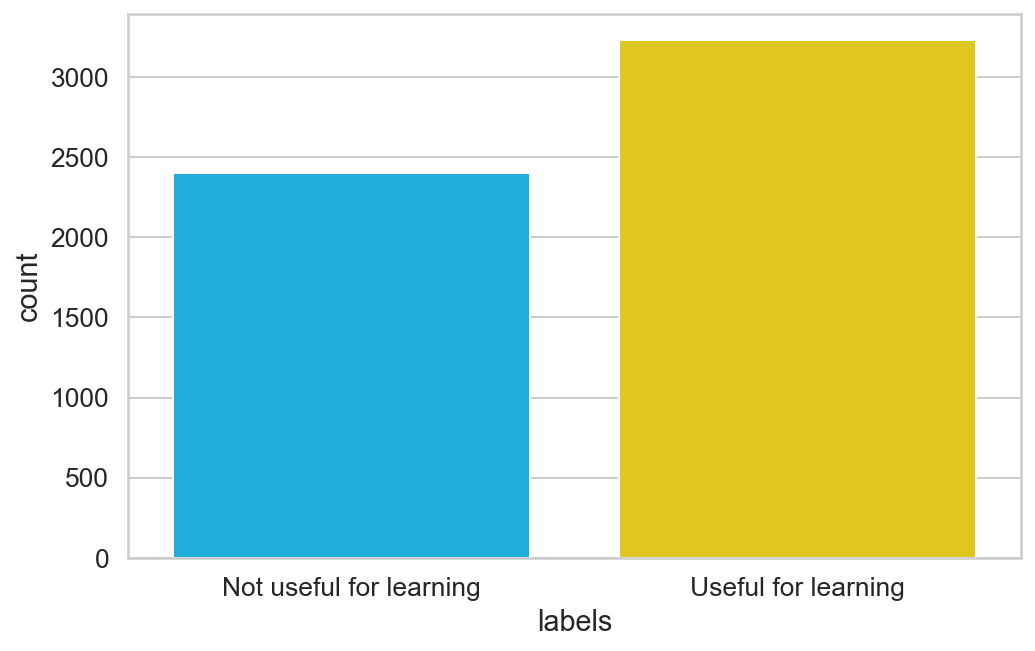

In [14]:
ax = sns.countplot(df.labels)
class_names = ['Not useful for learning', 'Useful for learning']
plt.xlabel('labels')
ax.set_xticklabels(class_names)

In [15]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
sample_txt = dataset["train"]["text"][i]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: \n{sample_txt}')
print(f'   Tokens: \n{tokens}')
print(f'Token IDs: \n{token_ids}')
print(f"SEP token \n{tokenizer.sep_token}, \nsep_token_id {tokenizer.sep_token_id}")
print(f"CLS token \n{tokenizer.cls_token}, \ncls_token_id {tokenizer.cls_token_id}")
print(f"PAD token \n{tokenizer.pad_token}, \npad_token_id {tokenizer.pad_token_id}")
print(f"UNK token \n{tokenizer.unk_token}, \nunk_token_id {tokenizer.unk_token_id}")

 Sentence: 
but what i would like to ask - what are the algorithms considered to implement the biggest amount of advanced techniques in computational and/or natural sciences ?
   Tokens: 
['but', 'what', 'i', 'would', 'like', 'to', 'ask', '-', 'what', 'are', 'the', 'algorithms', 'considered', 'to', 'implement', 'the', 'biggest', 'amount', 'of', 'advanced', 'techniques', 'in', 'computational', 'and', '/', 'or', 'natural', 'sciences', '?']
Token IDs: 
[1133, 1184, 178, 1156, 1176, 1106, 2367, 118, 1184, 1132, 1103, 14975, 1737, 1106, 10407, 1103, 4583, 2971, 1104, 3682, 4884, 1107, 19903, 1105, 120, 1137, 2379, 8614, 136]
SEP token 
[SEP], 
sep_token_id 102
CLS token 
[CLS], 
cls_token_id 101
PAD token 
[PAD], 
pad_token_id 0
UNK token 
[UNK], 
unk_token_id 100


In [17]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [18]:
print(len(encoding['input_ids'][0]), encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]), encoding['attention_mask'][0])
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


32 tensor([  101,  1133,  1184,   178,  1156,  1176,  1106,  2367,   118,  1184,
         1132,  1103, 14975,  1737,  1106, 10407,  1103,  4583,  2971,  1104,
         3682,  4884,  1107, 19903,  1105,   120,  1137,  2379,  8614,   136,
          102,     0])
32 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0])


['[CLS]',
 'but',
 'what',
 'i',
 'would',
 'like',
 'to',
 'ask',
 '-',
 'what',
 'are',
 'the',
 'algorithms',
 'considered',
 'to',
 'implement',
 'the',
 'biggest',
 'amount',
 'of',
 'advanced',
 'techniques',
 'in',
 'computational',
 'and',
 '/',
 'or',
 'natural',
 'sciences',
 '?',
 '[SEP]',
 '[PAD]']

In [19]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

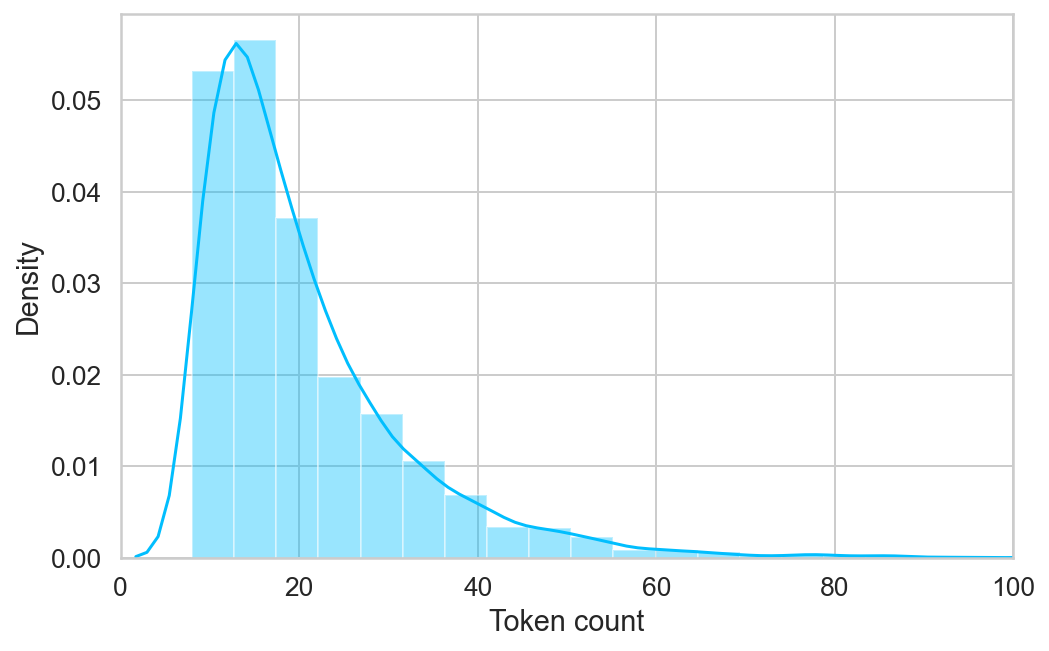

In [20]:
sns.distplot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')